In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import norm, beta
from scipy.optimize import minimize, differential_evolution

$f$ - неизвестная функция, минимум которой мы хотим найти ( в данном примере мы задаём её явно - это функция михалевица - и притворяемся, что не знаем её)

In [2]:
RANK = 1 # Раземерность куба, на котором определена наша функция
L = np.array([7]) # Куб будет со стороной 2*L и центром в 0

In [3]:
def f(x):
    y = 0
    for i in range(RANK):
        y = y + np.sin(x[:, i]) * np.sin(x[:, i]**2 / np.pi)
    return y

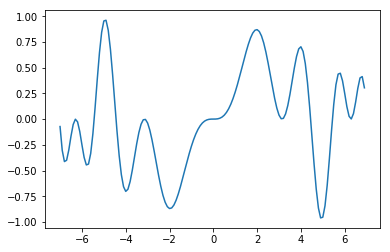

In [4]:
x = np.arange(-L,L,0.1).reshape(-1,RANK)
plt.plot(x, f(x))
plt.show()

generate_value генерирует значения из нормального распределения с мат.ожиданием f(x) (в LHCb ECal за это отвечает долгая симуляция)

In [5]:
def generate_value(f, x, sigma=0.01):
    return np.random.normal(f(x), sigma).reshape(x.shape[0], 1)

Байесовская оптимизация black-box функции с помощью гауссовских процессов состоит из нескольких шагов, выполняющихся последовательно:
1) Построение регрессионной модели (с помощью гауссовского процесса)
2) Вычисление Expected Improvement'а
3) Максимизация Expected Improvementa (т.е. поиск новой точки для вычисления black-box'а)

Первоначальная генерация датасета. Variance у kernel'а отвечает за эксплорейшн, чем больше variance - тем активней мы исследуем неизвестные области. Чем он меньше - тем больше мы уверены в том, что значение функции в области определяется соседними точками. Noise var - это аналог sigma (только возведённый в квадрат) из generate_value

In [6]:
X = np.random.uniform(-L, L, [1,RANK])
Y = generate_value(f, X)
opt_value = np.min(Y)
ker = GPy.kern.RBF(RANK, variance=1)
m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)

Основная часть оптимизации

In [7]:
def EI(x, model, opt_value):
    mean_value, variance_value = model.predict(x.reshape(1,RANK))
    std_value = np.sqrt(variance_value)
    improvement = (opt_value - mean_value).ravel()
    std_value = std_value.ravel()
    EI = improvement * norm.cdf(improvement / std_value) + std_value * norm.pdf(improvement / std_value)    
    return EI

In [8]:
def get_new_point(X, Y, model, opt_value):

    starting_points = np.random.uniform(-L, L, [10, RANK])
    
    max_EI = np.inf
    for starting_point in starting_points:
        current_EI = minimize(lambda t: -EI(t, model, opt_value), starting_point, \
                            method='L-BFGS-B', bounds=np.vstack((-L, L)).T)
        if current_EI.fun < max_EI:
            max_EI = current_EI.fun
            new_point = current_EI.x.reshape(1,RANK)
    new_value = generate_value(f, new_point)
    

    return new_point, new_value

In [9]:
for _ in trange(50):
    m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)
    x,y = get_new_point(X, Y, m, opt_value)
    X = np.append(X, x, axis=0)
    Y = np.append(Y, y, axis=0)
    opt_value = np.min(Y)

100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


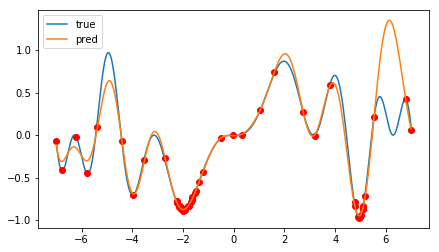

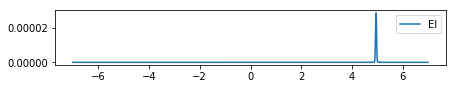

In [10]:
x = np.arange(-L,L,0.01).reshape(-1,1)
plt.figure(figsize=[7,4])
plt.plot(x, f(x), label='true')
plt.plot(X, Y, 'ro')
plt.plot(x, m.predict(x)[0], label='pred')
plt.legend()
plt.show()
plt.figure(figsize=[7,1])
plt.plot(x, [EI(i, m, opt_value) for i in x], label='EI')
plt.legend()
plt.show()